In [176]:
import os
import pandas as pd
import re
import string
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import precision_recall_fscore_support as score
import time
import matplotlib.pyplot as plt
import operator
import numpy as np
import matplotlib
from wordcloud import WordCloud

In [83]:
news = pd.read_csv("news.csv")
news.head()

,ID,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


# Clean and lemmatize title and text

Also looked at two further parameters: text length and percentage punctuation. They were also added to the classifier training.

In [84]:
wn = nltk.WordNetLemmatizer()
stopwords = nltk.corpus.stopwords.words('english')

def clean_text(text):
    text = "".join([word for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text)
    tokenized_text = [word for word in tokens if word not in stopwords]
    lem_text = [wn.lemmatize(word) for word in tokenized_text]
    return lem_text

def count_punct(text):
    count = sum([1 for char in text if char in string.punctuation])
#     print(len(text))
#     print(text.count(" "))
    try:
        return round(count/(len(text) - text.count(" ")), 3)*100
    except:
        return 0

news["text_len"] = news["text"].apply(lambda x: len(x) - x.count(" "))
news["punct%"] = news["text"].apply(lambda x: count_punct(x))

news.head()

,ID,title,text,label,text_len,punct%
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,6221,1.7
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,2201,2.9
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,2121,2.0
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,2257,3.5
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL,1534,4.2


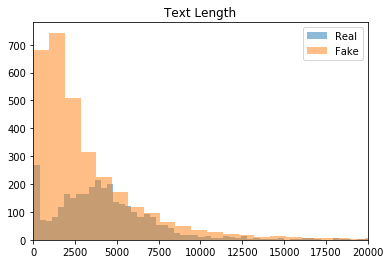

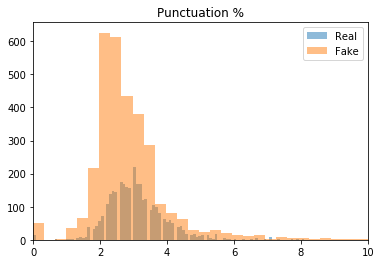

In [85]:
text_len_real = news[news["label"] == "REAL"]["text_len"]
text_len_fake = news[news["label"] == "FAKE"]["text_len"]

punct_real = news[news["label"] == "REAL"]["punct%"]
punct_fake = news[news["label"] == "FAKE"]["punct%"]

plt.hist(text_len_real,alpha=0.5,bins=100,label="Real")
plt.hist(text_len_fake,alpha=0.5,bins=100,label="Fake")
plt.title("Text Length")
plt.legend()
plt.xlim(0,20000)
plt.show()

plt.hist(punct_real,alpha=0.5,bins=100,label="Real")
plt.hist(punct_fake,alpha=0.5,bins=100,label="Fake")
plt.title("Punctuation %")
plt.legend()
plt.xlim(0,10)
plt.show()

# Split into Train and Test

In [86]:
X_train, X_test, y_train, y_test = train_test_split(news[["text","punct%","text_len"]], news["label"],test_size=0.2)

# TFIDF Vectorising

In [94]:
tfidf_vect = TfidfVectorizer(analyzer=clean_text)
tfidf_vect_fit = tfidf_vect.fit(X_train["text"])

tfidf_train = tfidf_vect_fit.transform(X_train["text"])
tfidf_test = tfidf_vect_fit.transform(X_test["text"])

X_train_vect = pd.concat([X_train[['text_len', 'punct%']].reset_index(drop=True), 
           pd.DataFrame(tfidf_train.toarray())], axis=1)
X_test_vect = pd.concat([X_test[['text_len', 'punct%']].reset_index(drop=True), 
           pd.DataFrame(tfidf_test.toarray())], axis=1)

X_train_vect.columns = ["text_len","punct%"]+tfidf_vect.get_feature_names()
X_test_vect.columns = ["text_len","punct%"]+tfidf_vect.get_feature_names()

X_train_vect.head()

,text_len,punct%,,0,00,000,0000,0000000031,0000035,00001400,...,عربي,عن,لم,ما,محاولات,من,هذا,والمرضى,ยงade,⅔
0,7109,2.4,0.013055,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,6279,4.3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1596,2.4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2436,2.4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3795,2.4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Train Random Forest Classifier

In [95]:
rf = RandomForestClassifier(n_estimators=150, max_depth=None, n_jobs=-1)

start = time.time()
rf_model = rf.fit(X_train_vect, y_train)
end = time.time()
fit_time = (end - start)

start = time.time()
y_pred = rf_model.predict(X_test_vect)
end = time.time()
pred_time = (end - start)

precision, recall, fscore, train_support = score(y_test, y_pred, pos_label='REAL', average='binary')
print('Fit time: {} / Predict time: {} ---- Precision: {} / Recall: {} / Accuracy: {}'.format(
    round(fit_time, 3), round(pred_time, 3), round(precision, 3), round(recall, 3), round((y_pred==y_test).sum()/len(y_pred), 3)))

Fit time: 35.451 / Predict time: 2.352 ---- Precision: 0.904 / Recall: 0.909 / Accuracy: 0.909


In [89]:
gb = GradientBoostingClassifier(n_estimators=150, max_depth=11)

start = time.time()
gb_model = gb.fit(X_train_vect, y_train)
end = time.time()
fit_time = (end - start)

start = time.time()
y_pred = gb_model.predict(X_test_vect)
end = time.time()
pred_time = (end - start)

precision, recall, fscore, train_support = score(y_test, y_pred, pos_label='REAL', average='binary')
print('Fit time: {} / Predict time: {} ---- Precision: {} / Recall: {} / Accuracy: {}'.format(
    round(fit_time, 3), round(pred_time, 3), round(precision, 3), round(recall, 3), round((y_pred==y_test).sum()/len(y_pred), 3)))

KeyboardInterrupt: 

In [72]:
print(len(news[news["label"]=="REAL"]))
print(len(news[news["label"]=="FAKE"]))

3171
3164


In [106]:
feats = {}
for n,i in zip(X_train_vect.columns,rf_model.feature_importances_):
    feats[i] = n
    


In [162]:
k_sorted = sorted(feats.keys(),reverse=True)
top_50 = [feats[i] for i in k_sorted[0:52] if feats[i] not in ["text_len","punct%"]]
len(top_50)

50

In [163]:
for t in top_50:
    print(t)

said
Obama
Republican
But
2016
president
October
conservative
Sen
GOP
primary
Republicans
candidate
Ted
House
Cruz
dont
senator
Tuesday
party
administration
tax
campaign

two
presidential
Gov
also
week
dismantling
The
Fox
Hillary
New
Senate
Killing
Share
would
nominee
President
Its
debate
Democratic
Bush
whether
0
A
didnt
By
pushing


In [124]:
news["lemmatized"] = news["text"].apply(lambda x: clean_text(x))

In [164]:
def count_word(word):
    d_counts = {"REAL":0,"FAKE":0}
    for row in news[["lemmatized","label"]].iterrows():
        if row[1]["label"] == "REAL":
            d_counts["REAL"] += row[1]["lemmatized"].count(word)
        else:
            d_counts["FAKE"] += row[1]["lemmatized"].count(word)
    return d_counts

In [165]:
words = []
real = []
fake = []

for word in top_50:
    counts = count_word(word)
    words.append(word)
    real.append(counts["REAL"])
    fake.append(counts["FAKE"])

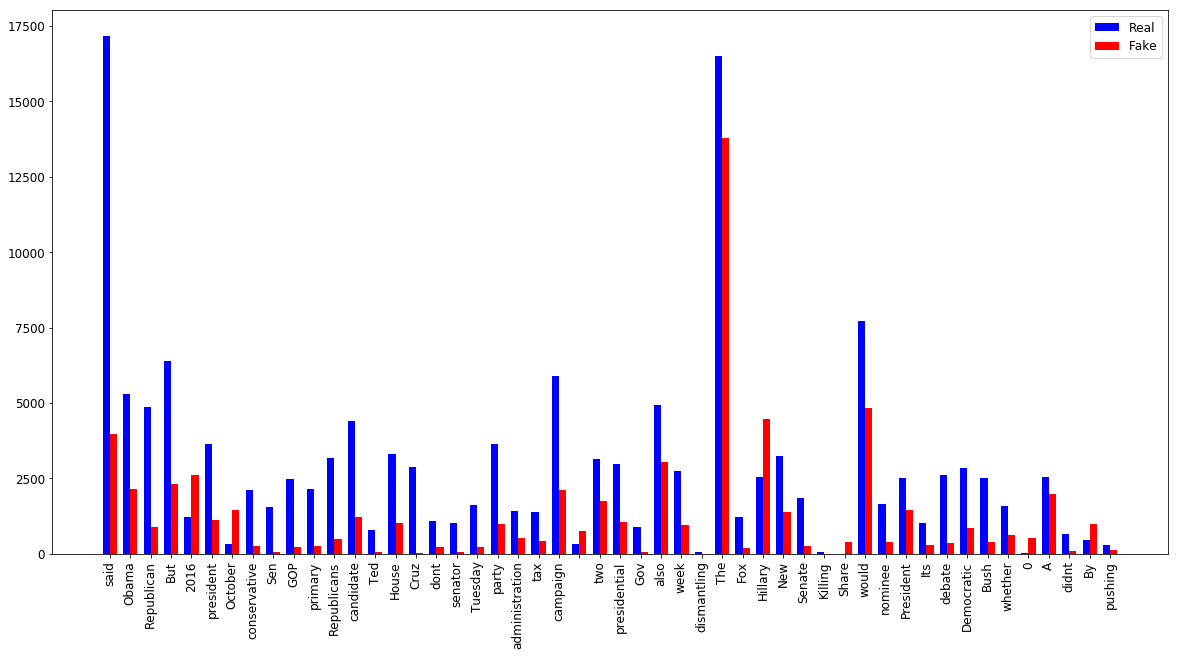

In [169]:
font = {'family' : 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)

N=len(words)
ind = np.arange(N)
width = 0.35

f,ax = plt.subplots(figsize=(20,10))

rects1 = ax.bar(ind,real,width=width,color='b',label="Real")
rects2 = ax.bar(ind+width,fake,width=width,color='r',label="Fake")

ax.set_xticks(ind+width/2)
ax.set_xticklabels(words,rotation=90)

plt.legend()

plt.show()

In [174]:
real_text = news[news["label"] == "REAL"]["text"]
fake_text = news[news["label"] == "FAKE"]["text"]

real_string = " ".join(real_text)
fake_string = " ".join(fake_text)

/Users/sm002/anaconda2/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


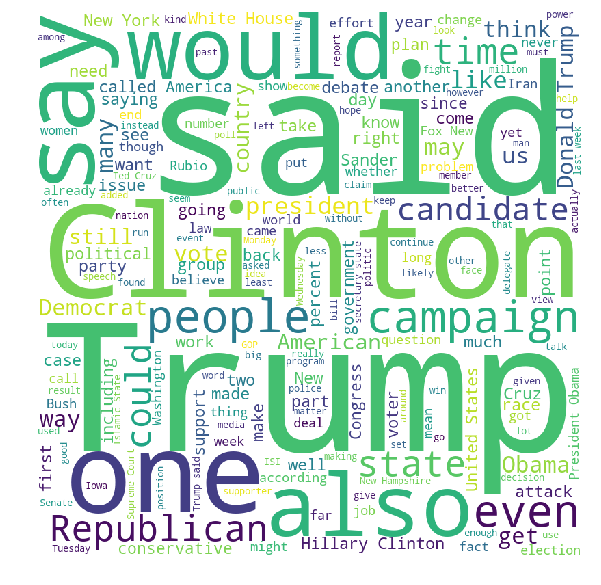

In [177]:
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(real_string) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

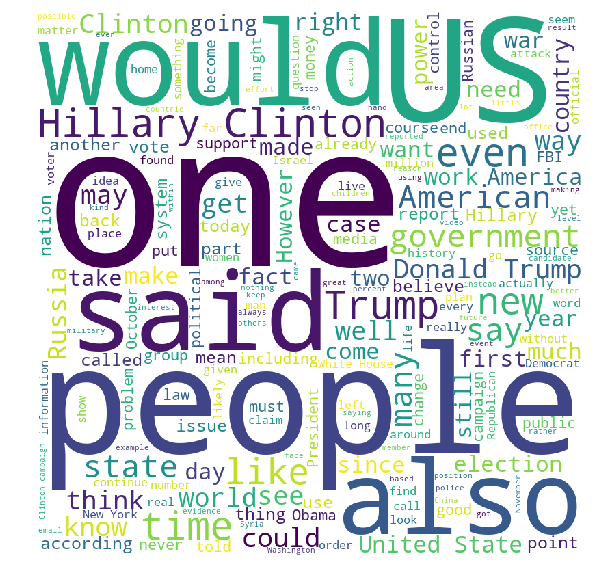

In [178]:
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(fake_string) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 